# PSOVA1
- Inertia Weight (w): It is a fixed parameter in your code but could be adjusted in PSOVA1 for dynamic control of exploration vs. exploitation.
- Cognitive and Social Constants (c1, c2): Similarly, in PSOVA1, these constants could be varied based on performance, adapting the search to focus on exploration or exploitation at different stages.
- Hybrid Dispatching and Leader Enhancement: These techniques are used to improve search diversity and adjust the global leader dynamically to enhance convergence to a better solution.
- Nonlinear Velocity Coefficients: The random generation of velocity coefficients allows the algorithm to adjust its search behavior based on the particle's individual performance.

Iteration 1: Best score = 574539.0
Iteration 2: Best score = 574539.0
Iteration 3: Best score = 574539.0
Iteration 4: Best score = 574539.0
Iteration 5: Best score = 574539.0
Iteration 6: Best score = 574539.0
Iteration 7: Best score = 574539.0
Iteration 8: Best score = 574539.0
Iteration 9: Best score = 574539.0
Iteration 10: Best score = 574539.0
Iteration 11: Best score = 574539.0
Iteration 12: Best score = 574539.0
Iteration 13: Best score = 574539.0
Iteration 14: Best score = 574539.0
Iteration 15: Best score = 574539.0
Iteration 16: Best score = 574539.0
Iteration 17: Best score = 574539.0
Iteration 18: Best score = 574539.0
Iteration 19: Best score = 574539.0
Iteration 20: Best score = 574539.0
Iteration 21: Best score = 574539.0
Iteration 22: Best score = 574539.0
Iteration 23: Best score = 574539.0
Iteration 24: Best score = 574539.0
Iteration 25: Best score = 574539.0
Iteration 26: Best score = 574539.0
Iteration 27: Best score = 574539.0
Iteration 28: Best score = 574539.0
I

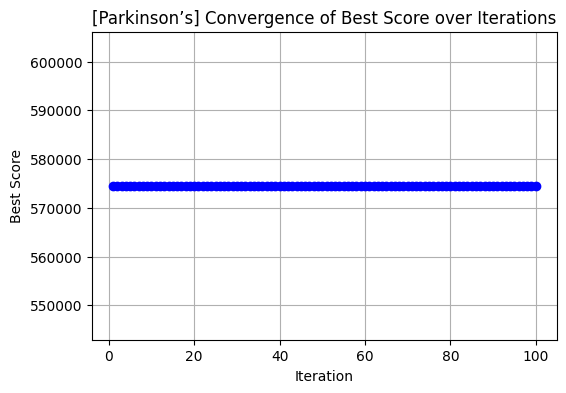

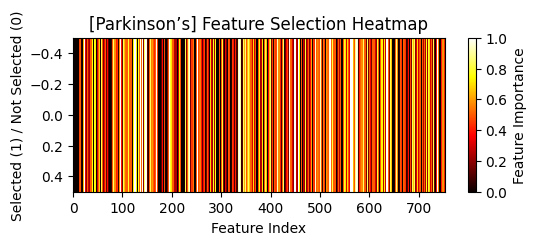



Mean Best Score: 574539.0
Standard Deviation of Best Score: 0.0
Mean Classification Accuracy: 0.7868421052631579
Standard Deviation of Classification Accuracy: 0.037701444162880016



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

random_state = 1922
np.random.seed(random_state)

# Load Parkinson's dataset
file_path = '../../data/raw/Parkinsons/pd_speech_features.csv'
def load_data(file_path):
    data = pd.read_csv(file_path)
    features = data.iloc[:, 1:-1].copy()  # Explicitly create a copy of the DataFrame
    labels = data.iloc[:, -1].values
    encoder = LabelEncoder()

    # Now using .loc to ensure modification is done safely
    for col in features.columns:
        if features[col].dtype == 'object':
            features.loc[:, col] = encoder.fit_transform(features[col])

    features = features.values
    return features, labels

features, labels = load_data(file_path)

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# PSOVA1 Parameters
w = 0.7
c1 = 1.2  # Cognitive constant
c2 = 1.8  # Social constant
max_iter = 100
swarm_size = 30
pswitch = 0.5

# Objective Function for PSOVA1
def objective_function(x, features, labels):
    selected_features = features[:, x.astype(bool)]
    score = np.sum(np.square(selected_features)) if selected_features.size > 0 else 0
    penalty = 1000 * np.sum(x)
    return score + penalty

# Particle initialization
def initialize_particles(dim):
    positions = (np.random.rand(swarm_size, dim) < 0.5).astype(int)
    velocities = np.random.uniform(-1, 1, (swarm_size, dim))
    return positions, velocities

# Equation 1: Velocity update with rectified personal and global best signals
'''
[1.1] Rectified (non-negative) personal best influence
[1.2] Rectified (non-negative) global best influence
The velocity update here uses the best positions, both personal best (pbest) and global best (gbest),
and adjusts them dynamically during the optimization process.
This rectifies the influence of global and personal best signals.
'''
def update_velocity(velocity, position, pbest, gbest):
    r1, r2 = np.random.rand(*position.shape[1:]), np.random.rand(*position.shape[1:])
    inertia = w * velocity
    cognitive = c1 * r1 * np.maximum(pbest - position, 0)  # [1.1]
    social = c2 * r2 * np.maximum(gbest - position, 0)     # [1.2]
    return inertia + cognitive + social

# Equation 2: Position update
def update_position(position, velocity):
    new_position = position + np.round(velocity).astype(int)
    return (new_position > 0).astype(int)

# Equation 3: Gaussian Leader Enhancement
'''
[2] Gaussian distribution based swarm leader enhancement
The global best (leader) is enhanced using Gaussian distribution to fine-tune the search.
This approach helps in exploring the search space and potentially avoiding local optima.
'''
def gaussian_leader_enhancement(gbest, upper_bound, lower_bound):
    alpha = 0.1
    skewness = np.random.choice([-1, 0, 1])
    return gbest + alpha * np.random.normal(skewness) * (upper_bound - lower_bound)

# Equation 4: Mirroring-based Mutation
'''
[4] Mirroring-based mutation operation
Mirroring-based Mutation is a type of mutation operation often used in optimization algorithms 
to improve the diversity of solutions and escape local optima.
'''
def mirroring_mutation(gbest):
    mutation_probability = 0.1
    new_solution = np.where(np.random.rand(gbest.shape[0]) < mutation_probability, ~gbest.astype(bool), gbest)
    return new_solution.astype(int)

# Equations 5-6: Differential Evolution-based Mutation
'''
[4] Differential Evolution mutation for worst solution improvement
Differential Evolution (DE) mutation and mirroring strategies are used to improve the worst solutions.
This helps diversify the swarm and avoid stagnation at local optima.
'''
def de_mutation(pbest1, pbest2, pbest3):
    F = np.random.rand()
    donor = pbest1 ^ (pbest2 ^ pbest3)
    return donor

# Equation 7: Annealing Schedule for Acceptance
def annealing_acceptance(delta_f, temperature):
    value = -delta_f / temperature
    value = np.clip(value, -709, 709)
    return np.exp(value) > np.random.rand()

# Equation 11: Spiral-based Local Exploitation
'''
[5] Spiral search based local exploitation
A spiral pattern search mechanism for local exploitation (fine-tuning the solutions) is employed here.
It involves adjusting particle positions according to a spiral function for better convergence.
'''
def spiral_search(gbest, particle_position):
    l = np.random.uniform(-1, 1)
    D = np.abs(gbest - particle_position)
    return D * np.exp(l) * np.cos(2 * np.pi * l) + gbest

# Main PSOVA1 algorithm
def PSOVA1(features, labels):
    dim = features.shape[1]
    positions, velocities = initialize_particles(dim)
    pbest_positions = np.copy(positions)
    pbest_scores = np.array([objective_function(p, features, labels) for p in pbest_positions])
    gbest_position = pbest_positions[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)

    best_scores_over_time = []
    temperature = 1.0

    for iteration in range(max_iter):
        for i in range(swarm_size):
            if pbest_scores[i] < gbest_score:
                gbest_position = pbest_positions[i]
                gbest_score = pbest_scores[i]

        for i in range(swarm_size):
            velocities[i] = update_velocity(velocities[i], positions[i], pbest_positions[i], gbest_position)
            positions[i] = update_position(positions[i], velocities[i])

            fitness = objective_function(positions[i], features, labels)
            if fitness < pbest_scores[i]:
                pbest_positions[i] = positions[i]
                pbest_scores[i] = fitness
            if fitness < gbest_score:
                gbest_position = positions[i]
                gbest_score = fitness

        best_scores_over_time.append(gbest_score)
        print(f"Iteration {iteration + 1}: Best score = {gbest_score}")
        temperature *= 0.9

    return gbest_position, gbest_score, best_scores_over_time

# Classification accuracy calculation
def calculate_accuracy(features, labels, best_position, num_trials=10):
    accuracies = []
    selected_features = features[:, best_position.astype(bool)]

    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=None)
        classifier = LogisticRegression(max_iter=500)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Run PSOVA1 on Parkinson's dataset and capture best score over time
best_position, best_score, best_scores_over_time = PSOVA1(features, labels)
mean_accuracy, std_accuracy = calculate_accuracy(features, labels, best_position)

# Calculate mean and standard deviation of best scores
mean_score = np.mean(best_scores_over_time)
std_score = np.std(best_scores_over_time)

# Visualization of best score over iterations
print("")
print("="*110)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_iter + 1), best_scores_over_time, marker='o', color='b')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('[Parkinson’s] Convergence of Best Score over Iterations')
plt.grid()
plt.show()

# Visualize best position in a feature heatmap
plt.figure(figsize=(6, 2))
plt.imshow(best_position.reshape(1, -1), cmap='hot', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.title('[Parkinson’s] Feature Selection Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.show()

# Print results
print("")
print("="*110)
print("")
print("Mean Best Score:", mean_score)
print("Standard Deviation of Best Score:", std_score)
print("Mean Classification Accuracy:", mean_accuracy)
print("Standard Deviation of Classification Accuracy:", std_accuracy)
print("")
print("="*110)
